In [151]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from scipy.special import expit
import scipy.special
import matplotlib.ticker as mtick
import torch
import patsy
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import StandardScaler
import bambi as bmb
import arviz as az
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import pymc as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import arviz as az
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings('ignore')

# File paths
DATA_DIR = Path("app")
FG_FILE = Path("field_goal_attempts.csv")
PLAYERS_FILE = Path("kickers.csv")
OUTPUT_FILE = Path("leaderboard.csv")

In [103]:
def load_data(fg_path: Path, players_path: Path):
    fg = pd.read_csv(fg_path)
    players = pd.read_csv(players_path)
    return fg, players

fg_raw, players_raw = load_data(FG_FILE, PLAYERS_FILE)
fg_raw.head()

,season,season_type,week,game_date,game_key,play_id,play_sequence,player_id,field_goal_result,attempt_yards
0,2010,Pre,1,8/8/2010,55073,433,17,34623,Made,20
1,2010,Pre,1,8/8/2010,55073,2661,104,34623,Missed,49
2,2010,Pre,1,8/8/2010,55073,2772,109,34623,Made,23
3,2010,Pre,1,8/8/2010,55073,1604,64,34623,Made,34
4,2010,Pre,2,8/12/2010,55076,3086,123,34623,Made,28


In [104]:
def preprocess_fg_data(fg):
    fg = fg[(fg['season_type'] == 'Reg')]
    fg = fg[fg['field_goal_result'].isin(['Made', 'Missed'])]
    fg['make'] = fg['field_goal_result'].map({'Made': 1, 'Missed': 0})
    return fg.copy()

fg_clean = preprocess_fg_data(fg_raw)
fg_clean.head()

,season,season_type,week,game_date,game_key,play_id,play_sequence,player_id,field_goal_result,attempt_yards,make
232,2010,Reg,1,9/9/2010,54863,1423,53,22912,Made,41,1
233,2010,Reg,1,9/9/2010,54863,1793,67,33337,Missed,46,0
234,2010,Reg,1,9/9/2010,54863,3295,127,33337,Missed,32,0
235,2010,Reg,1,9/12/2010,54866,2073,84,21213,Made,20,1
236,2010,Reg,1,9/12/2010,54870,1564,65,27091,Missed,46,0


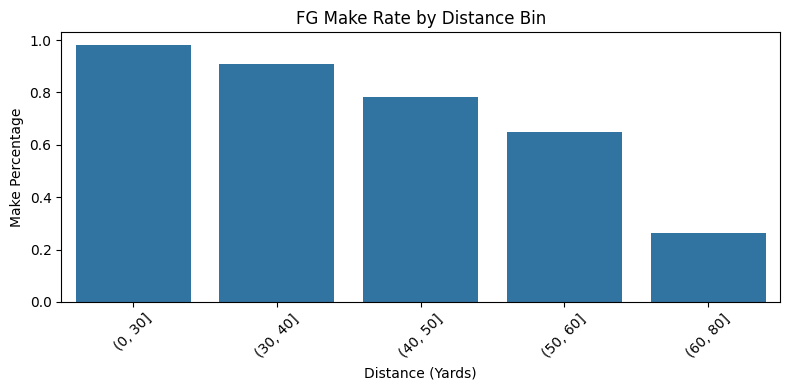

In [105]:
fg_clean['distance_bin'] = pd.cut(fg_clean['attempt_yards'], bins=[0, 30, 40, 50, 60, 80])
fg_bin_summary = fg_clean.groupby('distance_bin')['make'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=fg_bin_summary, x='distance_bin', y='make')
plt.title('FG Make Rate by Distance Bin')
plt.ylabel('Make Percentage')
plt.xlabel('Distance (Yards)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [106]:
# Enhanced Feature Engineering
fg_clean = fg_clean.sort_values(by=['player_id', 'season', 'game_date', 'play_sequence'])

# Attempt number features
fg_clean['attempt_number_in_game'] = fg_clean.groupby(['game_key', 'player_id']).cumcount() + 1
fg_clean['attempt_number_in_season'] = fg_clean.groupby('player_id').cumcount() + 1

# ✅ Fixed Prior makes in game (resets per game, only uses past attempts)
fg_clean['prior_makes_in_game'] = (
    fg_clean
    .groupby(['game_key', 'player_id'])['make']
    .transform(lambda x: x.shift().cumsum().fillna(0))
)

# Shift 'make' column by 1 to ensure streaks only use prior information
fg_clean['prior_make'] = fg_clean.groupby('player_id')['make'].shift()

# Makes in a row — cumulative streak ending before current row
fg_clean['makes_in_a_row'] = (
    fg_clean['prior_make']
    .groupby(fg_clean['player_id'])
    .transform(lambda x: x.groupby((x != x.shift()).cumsum()).cumcount() + 1) * fg_clean['prior_make'].fillna(0)
)

# Misses in a row — cumulative streak ending before current row
fg_clean['misses_in_a_row'] = (
    (1 - fg_clean['prior_make'])
    .groupby(fg_clean['player_id'])
    .transform(lambda x: x.groupby((x != x.shift()).cumsum()).cumcount() + 1) * (1 - fg_clean['prior_make'].fillna(1))
)

# Drop helper column
fg_clean.drop(columns=['prior_make'], inplace=True)

# Feature binning and casting to categorical
fg_clean['attempt_number_in_game_cat'] = fg_clean['attempt_number_in_game'].clip(upper=3).astype('category')

fg_clean['season_attempt_bin'] = pd.cut(
    fg_clean['attempt_number_in_season'],
    bins=[0, 5, 10, 20, 50, 100],
    labels=["1–5", "6–10", "11–20", "21–50", "51+"]
)

fg_clean['prior_makes_in_game'] = fg_clean['prior_makes_in_game'].astype('category')
fg_clean['makes_in_a_row_capped'] = fg_clean['makes_in_a_row'].clip(upper=3).astype('category')
fg_clean['misses_in_a_row_capped'] = fg_clean['misses_in_a_row'].clip(upper=2).astype('category')

# Fill remaining NAs for numeric columns
fg_clean = fg_clean.fillna({col: 0 for col in fg_clean.select_dtypes(include=['number']).columns})

# Preview
fg_clean[
    [
        'player_id',
        'attempt_number_in_game', 'attempt_number_in_game_cat',
        'attempt_number_in_season', 'season_attempt_bin',
        'prior_makes_in_game',
        'makes_in_a_row', 'makes_in_a_row_capped',
        'misses_in_a_row', 'misses_in_a_row_capped'
    ]
].head()

,player_id,attempt_number_in_game,attempt_number_in_game_cat,attempt_number_in_season,season_attempt_bin,prior_makes_in_game,makes_in_a_row,makes_in_a_row_capped,misses_in_a_row,misses_in_a_row_capped
479,5205,1,1,1,1–5,0.0,0.0,0.0,0.0,0.0
487,5205,2,2,2,1–5,1.0,1.0,1.0,0.0,0.0
495,5205,3,3,3,1–5,2.0,2.0,2.0,0.0,0.0
431,5205,1,1,4,1–5,0.0,0.0,0.0,1.0,1.0
435,5205,2,2,5,1–5,1.0,1.0,1.0,0.0,0.0


In [107]:
# ---- Feature Engineering ----
fg_clean = fg_clean.copy()

# Bin attempt number in game
fg_clean["attempt_number_in_game_cat"] = pd.cut(
    fg_clean["attempt_number_in_game"], bins=[0, 1, 2, 3, 10], labels=["1", "2", "3", "4+"]
)

# Bin attempt number in season
fg_clean["season_attempt_bin"] = pd.cut(
    fg_clean["attempt_number_in_season"], bins=[0, 5, 10, 20, 40, 1000], labels=["1–5", "6–10", "11–20", "21–40", "41+"]
)

# Cap streaks
fg_clean["makes_in_a_row_capped"] = fg_clean["makes_in_a_row"].clip(upper=5)
fg_clean["misses_in_a_row_capped"] = fg_clean["misses_in_a_row"].clip(upper=5)

# ---- Features and Target ----
numeric_features = ['attempt_yards']
categorical_features = [
    'attempt_number_in_game_cat',
    'season_attempt_bin',
    'prior_makes_in_game',
    'makes_in_a_row_capped',
    'misses_in_a_row_capped'
]
target = 'make'

# Create X and y
X = fg_clean[numeric_features + categorical_features]
y = fg_clean[target]

# ---- Train/Holdout Split ----
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---- Preprocessor ----
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# ---- Base Models ----
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": HistGradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_estimators=100
    )
}

# ---- Cross-Validation + Calibration ----
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
trained_models = {}

for name, clf in base_models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", clf)
    ])
    
    # CV Evaluation (Uncalibrated)
    logloss_scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring='neg_log_loss')
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring='roc_auc')
    
    results.append({
        'Model': name,
        'Log Loss (CV mean)': round(-logloss_scores.mean(), 4),
        'Log Loss (CV std)': round(logloss_scores.std(), 4),
        'ROC AUC (CV mean)': round(auc_scores.mean(), 4),
        'ROC AUC (CV std)': round(auc_scores.std(), 4)
    })
    
    # Fit full model (Uncalibrated)
    pipe.fit(X_train, y_train)
    trained_models[name] = pipe
    
    # Fit full model (Calibrated)
    method = 'sigmoid' if name == "Logistic Regression" else 'isotonic'
    calibrated_model = CalibratedClassifierCV(estimator=pipe, method=method, cv=5)
    calibrated_model.fit(X_train, y_train)
    trained_models[f"{name} (Calibrated)"] = calibrated_model

# ---- Holdout Evaluation ----
holdout_results = []
for name, model in trained_models.items():
    probs = model.predict_proba(X_holdout)[:, 1]
    loss = log_loss(y_holdout, probs)
    auc = roc_auc_score(y_holdout, probs)
    
    holdout_results.append({
        'Model': name,
        'Log Loss': round(loss, 4),
        'ROC AUC': round(auc, 4)
    })

# ---- Final Display ----
holdout_df = pd.DataFrame(holdout_results)
final_df = holdout_df.sort_values("Log Loss").reset_index(drop=True)

display(final_df)

,Model,Log Loss,ROC AUC
0,Logistic Regression (Calibrated),0.3622,0.7390
1,Logistic Regression,0.3630,0.7390
2,XGBoost (Calibrated),0.3685,0.7131
3,Gradient Boosting (Calibrated),0.3694,0.7166
4,Random Forest (Calibrated),0.3760,0.6952
5,Naive Bayes (Calibrated),0.3761,0.6941
6,KNN (Calibrated),0.3770,0.6893
7,Gradient Boosting,0.3841,0.7162
8,XGBoost,0.3931,0.7074
9,Random Forest,0.9883,0.6897


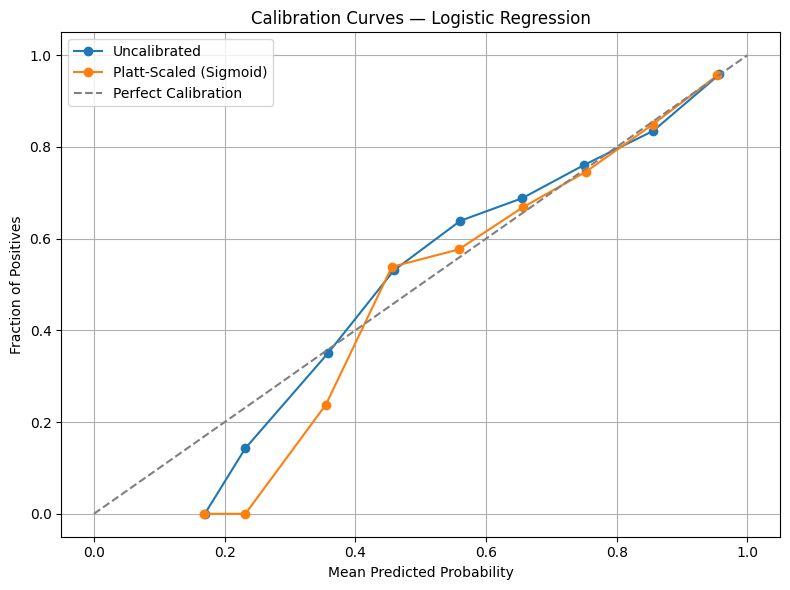

In [108]:
# Fit calibrated model using Platt scaling (sigmoid)
calibrated_model = CalibratedClassifierCV(
    estimator=uncalibrated_model, 
    method='sigmoid',
    cv=5
)
calibrated_model.fit(X, y)

# Predict probabilities
probs_uncalibrated = uncalibrated_model.predict_proba(X)[:, 1]
probs_calibrated = calibrated_model.predict_proba(X)[:, 1]

# Compute calibration curve values
fraction_uncal, mean_pred_uncal = calibration_curve(y, probs_uncalibrated, n_bins=10)
fraction_cal, mean_pred_cal = calibration_curve(y, probs_calibrated, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_pred_uncal, fraction_uncal, label='Uncalibrated', marker='o')
plt.plot(mean_pred_cal, fraction_cal, label='Platt-Scaled (Sigmoid)', marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curves — {best_model_name}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

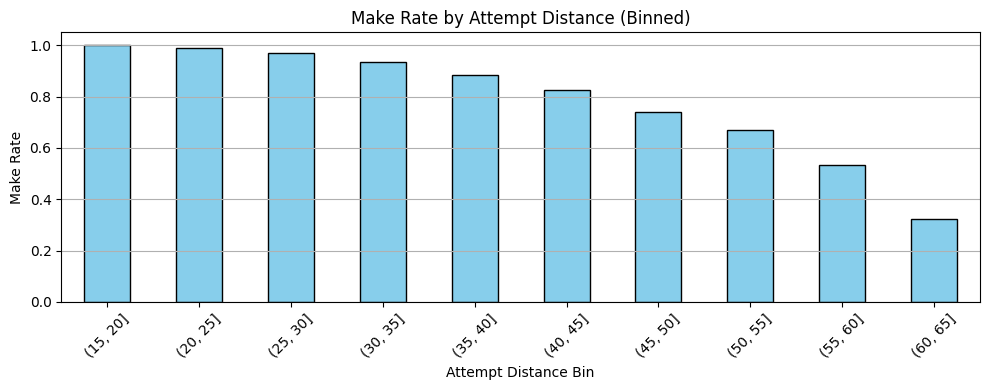

In [109]:
fg_clean['attempt_bin'] = pd.cut(fg_clean['attempt_yards'], bins=np.arange(15, 70, 5))
binned_make_rate = fg_clean.groupby('attempt_bin')['make'].mean()

plt.figure(figsize=(10, 4))
binned_make_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Make Rate by Attempt Distance (Binned)')
plt.ylabel('Make Rate')
plt.xlabel('Attempt Distance Bin')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

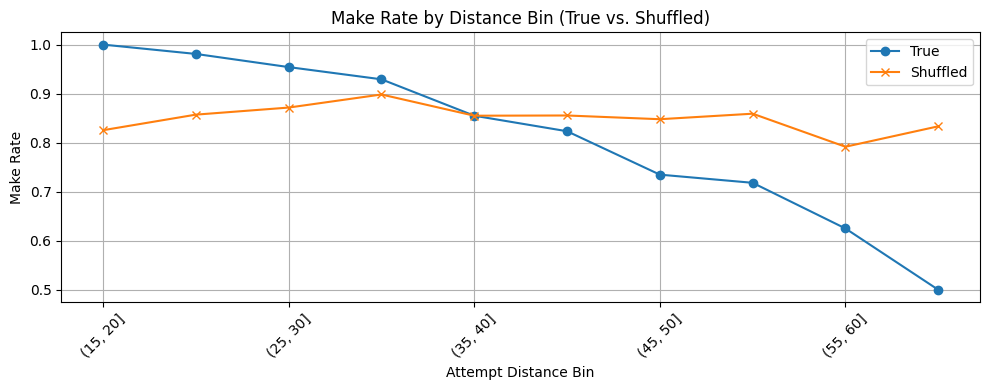

In [110]:
# Shuffle make labels to simulate noise
np.random.seed(42)
shuffled_make = y_holdout.sample(frac=1).reset_index(drop=True)

# Binning true and shuffled
X_holdout_copy = X_holdout.copy()
X_holdout_copy['true_make'] = y_holdout.values
X_holdout_copy['shuffled_make'] = shuffled_make.values
X_holdout_copy['attempt_bin'] = pd.cut(X_holdout_copy['attempt_yards'], bins=np.arange(15, 70, 5))

# Mean make rates per bin
true_rate = X_holdout_copy.groupby('attempt_bin')['true_make'].mean()
shuffled_rate = X_holdout_copy.groupby('attempt_bin')['shuffled_make'].mean()

# Plot
plt.figure(figsize=(10, 4))
true_rate.plot(label='True', marker='o')
shuffled_rate.plot(label='Shuffled', marker='x')
plt.title('Make Rate by Distance Bin (True vs. Shuffled)')
plt.ylabel('Make Rate')
plt.xlabel('Attempt Distance Bin')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

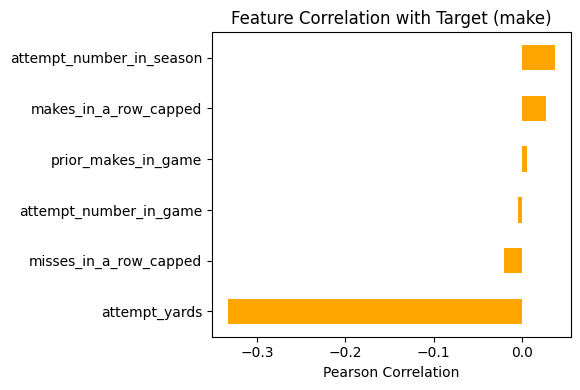

In [111]:
corrs = fg_clean[features + ['make']].corr()['make'].drop('make')
plt.figure(figsize=(6, 4))
corrs.sort_values().plot(kind='barh', color='orange')
plt.title('Feature Correlation with Target (make)')
plt.xlabel('Pearson Correlation')
plt.tight_layout()
plt.show()

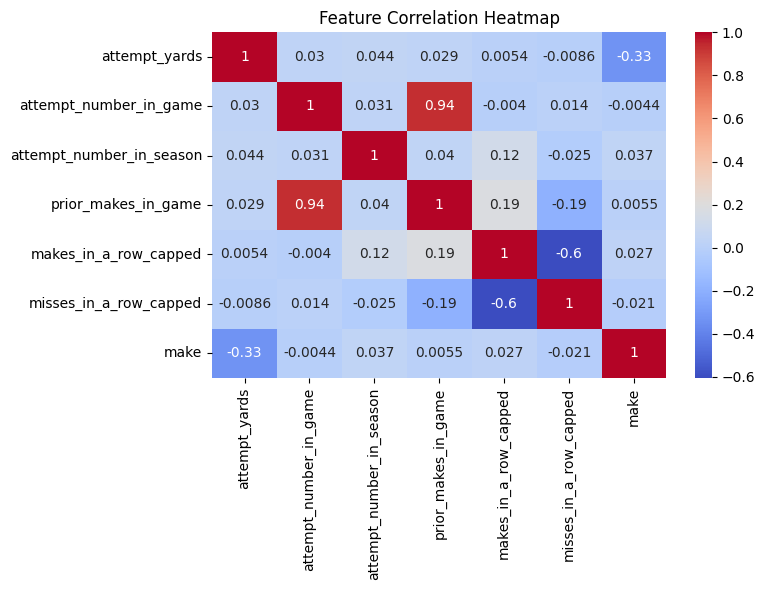

In [112]:
correlation_matrix = fg_clean[features + ['make']].corr()['make'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(fg_clean[features + ['make']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

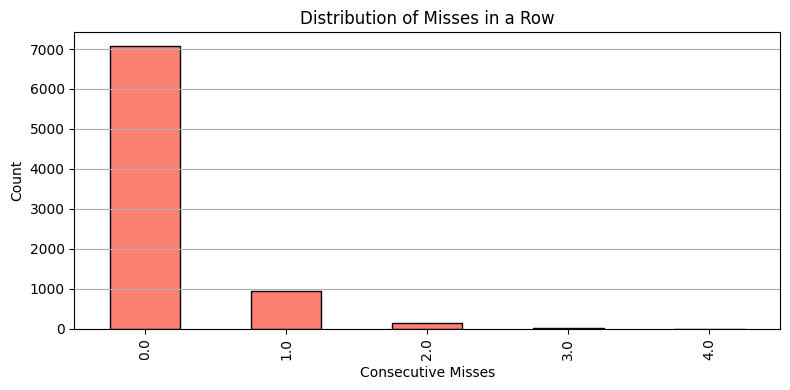

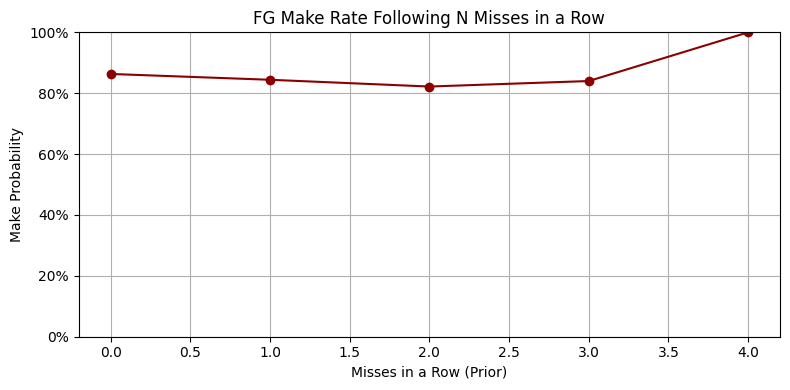

In [113]:
# Distribution of Misses in a Row
plt.figure(figsize=(8, 4))
fg_clean['misses_in_a_row'].value_counts().sort_index().plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Distribution of Misses in a Row")
plt.xlabel("Consecutive Misses")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Conditional Probability of Make Following N Misses
miss_streak_probs = (
    fg_clean.groupby('misses_in_a_row')['make']
    .agg(['count', 'mean'])
    .rename(columns={'mean': 'make_rate'})
    .reset_index()
)

plt.figure(figsize=(8, 4))
plt.plot(miss_streak_probs['misses_in_a_row'], miss_streak_probs['make_rate'], marker='o', color='darkred')
plt.title("FG Make Rate Following N Misses in a Row")
plt.xlabel("Misses in a Row (Prior)")
plt.ylabel("Make Probability")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

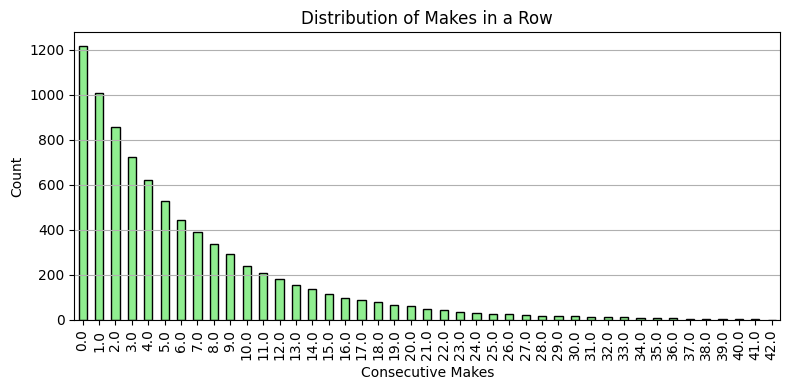

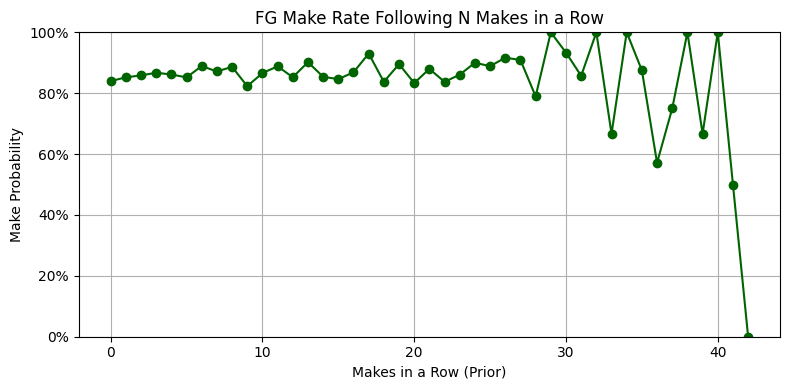

In [114]:
# Distribution of Makes in a Row
plt.figure(figsize=(8, 4))
fg_clean['makes_in_a_row'].value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Distribution of Makes in a Row")
plt.xlabel("Consecutive Makes")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Conditional Probability of Make Following N Makes
make_streak_probs = (
    fg_clean.groupby('makes_in_a_row')['make']
    .agg(['count', 'mean'])
    .rename(columns={'mean': 'make_rate'})
    .reset_index()
)

plt.figure(figsize=(8, 4))
plt.plot(make_streak_probs['makes_in_a_row'], make_streak_probs['make_rate'], marker='o', color='darkgreen')
plt.title("FG Make Rate Following N Makes in a Row")
plt.xlabel("Makes in a Row (Prior)")
plt.ylabel("Make Probability")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

In [116]:
# Step 1: Prepare training data (no sampling)
df_train = X_train.copy()
df_train["make"] = y_train
df_train = df_train[
    [
        "make",
        "attempt_yards",
        "attempt_number_in_game_cat",
        "season_attempt_bin",
        "prior_makes_in_game",
        "makes_in_a_row_capped",
        "misses_in_a_row_capped",
    ]
].dropna()

# One-hot encode categoricals
df_train_encoded = pd.get_dummies(df_train, columns=["attempt_number_in_game_cat", "season_attempt_bin"], drop_first=True)

# Scale numeric feature
scaler_bayes = StandardScaler()
df_train_encoded["attempt_yards_scaled"] = scaler_bayes.fit_transform(df_train_encoded[["attempt_yards"]])
df_train_encoded = df_train_encoded.drop(columns="attempt_yards")

# X, y for training
X_bayes_train = df_train_encoded.drop(columns="make").astype(float).values
y_bayes_train = df_train_encoded["make"].values

# Step 2: Fit PyMC model with MAP estimate
with pm.Model() as model_bayes:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    betas = pm.Normal("betas", mu=0, sigma=10, shape=X_bayes_train.shape[1])
    
    logits = intercept + pm.math.dot(X_bayes_train, betas)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))
    
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_bayes_train)
    
    map_estimate = pm.find_MAP()

df_holdout = X_holdout.copy()

# Add engineered features if needed (ensure these were computed for holdout)
# Assuming they were already present from earlier steps

df_holdout = X_holdout.copy()

# Step 1: Scale attempt_yards before dropping it
df_holdout["attempt_yards_scaled"] = scaler_bayes.transform(df_holdout[["attempt_yards"]])

# Step 2: Drop unscaled column
df_holdout = df_holdout.drop(columns="attempt_yards")

# Step 3: One-hot encode categoricals
df_holdout = pd.get_dummies(df_holdout, columns=["attempt_number_in_game_cat", "season_attempt_bin"], drop_first=True)

# Step 4: Reindex to match training columns
df_holdout = df_holdout.reindex(columns=df_train_encoded.drop(columns="make").columns, fill_value=0)

# Step 5: Convert to array
X_bayes_holdout = df_holdout.astype(float).values

# Step 6: Predict and calibrate
linpred_holdout = map_estimate["intercept"] + np.dot(X_bayes_holdout, map_estimate["betas"])
probs_bayes_uncal = 1 / (1 + np.exp(-linpred_holdout))

# Fit isotonic calibrator on holdout targets
base_model = LogisticRegression().fit(probs_bayes_uncal.reshape(-1, 1), y_holdout)

calibrator_bayes = CalibratedClassifierCV(estimator=base_model, method='isotonic', cv='prefit')
calibrator_bayes.fit(probs_bayes_uncal.reshape(-1, 1), y_holdout)

probs_bayes_cal = calibrator_bayes.predict_proba(probs_bayes_uncal.reshape(-1, 1))[:, 1]

# Step 5: Evaluate
loss_bayes_uncal = log_loss(y_holdout, probs_bayes_uncal)
auc_bayes_uncal = roc_auc_score(y_holdout, probs_bayes_uncal)
loss_bayes_cal = log_loss(y_holdout, probs_bayes_cal)
auc_bayes_cal = roc_auc_score(y_holdout, probs_bayes_cal)

print(f"✅ PyMC MAP (Uncalibrated) — Log Loss: {loss_bayes_uncal:.4f}, ROC AUC: {auc_bayes_uncal:.4f}")
print(f"✅ PyMC MAP (Calibrated w/ Isotonic) — Log Loss: {loss_bayes_cal:.4f}, ROC AUC: {auc_bayes_cal:.4f}")

✅ PyMC MAP (Uncalibrated) — Log Loss: 0.3612, ROC AUC: 0.7417
✅ PyMC MAP (Calibrated w/ Isotonic) — Log Loss: 0.3481, ROC AUC: 0.7497


In [153]:
# If X is a NumPy array, convert it to a DataFrame with column names
if isinstance(X, np.ndarray):
    X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode categorical columns
# One-hot encode categorical columns
X_train_encoded = pd.get_dummies(X_train)

# ✅ Save input column names used for later inference
nn_input_columns = X_train_encoded.columns.tolist()
joblib.dump(nn_input_columns, "nn_input_columns.pkl")

X_test_encoded = pd.get_dummies(X_test)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Reuse column structure from X_train_encoded used earlier
X_holdout_encoded = pd.get_dummies(X_holdout)
X_holdout_encoded = X_holdout_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Scale using previously fitted scaler
X_holdout_scaled = scaler.transform(X_holdout_encoded)

# Convert to tensor for PyTorch NN
X_holdout_tensor = torch.tensor(X_holdout_scaled, dtype=torch.float32)

# Build dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define neural net
class FGNet(nn.Module):
    def __init__(self, input_dim):
        super(FGNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Initialize model
model_nn = FGNet(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

# Train model
for epoch in range(30):
    model_nn.train()
    for xb, yb in train_loader:
        preds = model_nn(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate on test set
model_nn.eval()
with torch.no_grad():
    y_pred_nn = model_nn(X_test_tensor).numpy().flatten()

# Evaluate uncalibrated performance
loss_nn = log_loss(y_test, y_pred_nn)
auc_nn = roc_auc_score(y_test, y_pred_nn)

# Calibrate using Isotonic Regression
iso_calibrator = IsotonicRegression(out_of_bounds="clip")
iso_calibrator.fit(y_pred_nn, y_test)
y_pred_nn_calibrated = iso_calibrator.predict(y_pred_nn)

# Evaluate calibrated performance
loss_nn_cal = log_loss(y_test, y_pred_nn_calibrated)
auc_nn_cal = roc_auc_score(y_test, y_pred_nn_calibrated)

print(f"✅ Deep Learning (PyTorch NN) — Uncalibrated Log Loss: {loss_nn:.4f}, ROC AUC: {auc_nn:.4f}")
print(f"✅ Deep Learning (PyTorch NN) — Calibrated Log Loss:   {loss_nn_cal:.4f}, ROC AUC: {auc_nn_cal:.4f}")

# ✅ Predict on X_holdout for ensemble (must match ensemble length)
X_holdout_encoded = pd.get_dummies(X_holdout)
X_holdout_encoded = X_holdout_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_holdout_scaled = scaler.transform(X_holdout_encoded)
X_holdout_tensor = torch.tensor(X_holdout_scaled, dtype=torch.float32)

with torch.no_grad():
    y_pred_holdout_nn = model_nn(X_holdout_tensor).numpy().flatten()

# Calibrate holdout predictions
probs_nn_cal = iso_calibrator.predict(y_pred_holdout_nn)

✅ Deep Learning (PyTorch NN) — Uncalibrated Log Loss: 0.3356, ROC AUC: 0.7803
✅ Deep Learning (PyTorch NN) — Calibrated Log Loss:   0.3263, ROC AUC: 0.7882


In [28]:
# Save original indices before split
X_with_index = fg_clean[numeric_features + categorical_features].copy()
X_with_index["make"] = fg_clean["make"]
X_with_index["player_id"] = fg_clean["player_id"]
X_with_index["season"] = fg_clean["season"]

# Train-test split with indices retained
X_train, X_holdout = train_test_split(X_with_index, test_size=0.2, stratify=X_with_index["make"], random_state=42)

# Rebuild train/test sets from full dataframe (includes metadata now)
train_data = X_train.copy()
test_data = X_holdout.copy()

# Separate target
y_train = train_data.pop("make")
y_holdout = test_data.pop("make")

# Encode group indices
train_data["player_idx"] = train_data["player_id"].astype("category").cat.codes
train_data["season_idx"] = train_data["season"].astype("category").cat.codes
test_data["player_idx"] = test_data["player_id"].astype("category").cat.codes
test_data["season_idx"] = test_data["season"].astype("category").cat.codes

n_players = train_data["player_idx"].nunique()
n_seasons = train_data["season_idx"].nunique()

# Reset index to ensure alignment
train_data = train_data.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Build training design matrix
X = patsy.dmatrix("attempt_yards + attempt_number_in_game_cat + season_attempt_bin + "
                  "prior_makes_in_game + makes_in_a_row_capped + misses_in_a_row_capped - 1",
                  train_data, return_type="dataframe")

# Align y, player_idx, season_idx with design matrix X
aligned_idx = X.index
y = y_train.loc[aligned_idx].values
player_idx = train_data.loc[aligned_idx, "player_idx"].values
season_idx = train_data.loc[aligned_idx, "season_idx"].values

# Build PyMC model
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
    sigma_player = pm.HalfNormal("sigma_player", sigma=1)
    sigma_season = pm.HalfNormal("sigma_season", sigma=1)

    player_effect = pm.Normal("player_effect", mu=0, sigma=sigma_player, shape=n_players)
    season_effect = pm.Normal("season_effect", mu=0, sigma=sigma_season, shape=n_seasons)

    logits = pm.math.dot(X, beta) + player_effect[player_idx] + season_effect[season_idx]

    pm.Bernoulli("make", logit_p=logits, observed=y)

    approx = pm.fit(n=250, method="advi", progressbar=True)
    idata = approx.sample(500)

# Test design matrix with aligned indices
X_test = patsy.dmatrix("attempt_yards + attempt_number_in_game_cat + season_attempt_bin + "
                       "prior_makes_in_game + makes_in_a_row_capped + misses_in_a_row_capped - 1",
                       test_data, return_type="dataframe")

# Align test_data with X_test rows
test_data_aligned = test_data.loc[X_test.index].reset_index(drop=True)
y_holdout_aligned = y_holdout.loc[X_test.index].values
player_idx_test = test_data_aligned["player_idx"].values
season_idx_test = test_data_aligned["season_idx"].values

# Extract posterior samples
posterior_beta = idata.posterior["beta"].stack(draws=("chain", "draw")).values.T
posterior_player_effect = idata.posterior["player_effect"].stack(draws=("chain", "draw")).values.T
posterior_season_effect = idata.posterior["season_effect"].stack(draws=("chain", "draw")).values.T

# Check index bounds
if player_idx_test.max() >= posterior_player_effect.shape[1]:
    raise ValueError("Test data contains unseen player_id values.")
if season_idx_test.max() >= posterior_season_effect.shape[1]:
    raise ValueError("Test data contains unseen season values.")

# Predict
logits_test = (posterior_beta @ X_test.T +
               posterior_player_effect[:, player_idx_test] +
               posterior_season_effect[:, season_idx_test])
probs = 1 / (1 + np.exp(-logits_test))
mean_probs = probs.mean(axis=0)

# Evaluate before calibration
loss_pymc = log_loss(y_holdout_aligned, mean_probs)
auc_pymc = roc_auc_score(y_holdout_aligned, mean_probs)

# ✅ Isotonic Calibration
iso_reg = IsotonicRegression(out_of_bounds='clip')
iso_reg.fit(mean_probs, y_holdout_aligned)
probs_calibrated = iso_reg.transform(mean_probs)

# Evaluate after calibration
loss_pymc_cal = log_loss(y_holdout_aligned, probs_calibrated)
auc_pymc_cal = roc_auc_score(y_holdout_aligned, probs_calibrated)

print(f"✅ Mixed-Effects Model (Uncalibrated) — Log Loss: {loss_pymc:.4f}, ROC AUC: {auc_pymc:.4f}")
print(f"✅ Mixed-Effects Model (Calibrated w/ Isotonic) — Log Loss: {loss_pymc_cal:.4f}, ROC AUC: {auc_pymc_cal:.4f}")

Finished [100%]: Average Loss = 39,704


✅ Mixed-Effects Model (Uncalibrated) — Log Loss: 0.6673, ROC AUC: 0.5630
✅ Mixed-Effects Model (Calibrated w/ Isotonic) — Log Loss: 0.4104, ROC AUC: 0.5875


In [97]:
# ✅ Step 0: Recreate X and y from original data to preserve indices
predictor_cols = [
    "attempt_yards", "attempt_number_in_game", "attempt_number_in_season",
    "prior_makes_in_game", "makes_in_a_row", "misses_in_a_row"
]
X = fg_clean[predictor_cols]
y = fg_clean["make"]

# ✅ Step 1: Train/holdout split with index preserved
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 2: Reconstruct holdout_data from original fg_clean using preserved index
test_data = fg_clean.loc[X_holdout.index, predictor_cols].copy()
test_data["make"] = y_holdout.values
test_data["player_id"] = fg_clean.loc[X_holdout.index, "player_id"]

# ✅ Step 3: Fit uncalibrated logistic regression
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)
probs_uncal = logit_model.predict_proba(X_holdout)[:, 1]

# ✅ Step 4: Fit isotonic calibration on top of base model
calibrated_model = CalibratedClassifierCV(logit_model, method="isotonic", cv=5)
calibrated_model.fit(X_train, y_train)
probs_cal = calibrated_model.predict_proba(X_holdout)[:, 1]
probs_sim_cal = probs_cal  # rename for ensemble

# ✅ Step 5: Simulate 100 kicks per kicker using calibrated probabilities
sim_results = []
kickers = test_data["player_id"].unique()

for pid in kickers:
    player_probs = probs_cal[test_data["player_id"] == pid]
    if len(player_probs) == 0:
        continue
    sim_attempts = np.random.binomial(1, player_probs, size=(100, len(player_probs)))
    sim_makes = sim_attempts.sum(axis=1)
    sim_results.append({"player_id": pid, "avg_makes": sim_makes.mean()})

# ✅ Step 6: Output top simulated performers
sim_df = pd.DataFrame(sim_results)
sim_df = sim_df.merge(players_raw, on="player_id", how="left")

# ✅ Step 7: Evaluate both models
sim_loss_uncal = log_loss(y_holdout, probs_uncal)
sim_auc_uncal = roc_auc_score(y_holdout, probs_uncal)
sim_loss_cal = log_loss(y_holdout, probs_cal)
sim_auc_cal = roc_auc_score(y_holdout, probs_cal)

print(f"🎯 Simulation-Driven Model (Uncalibrated Logistic) — Log Loss: {sim_loss_uncal:.4f}, ROC AUC: {sim_auc_uncal:.4f}")
print(f"🎯 Simulation-Driven Model (Calibrated w/ Isotonic) — Log Loss: {sim_loss_cal:.4f}, ROC AUC: {sim_auc_cal:.4f}")

🎯 Simulation-Driven Model (Uncalibrated Logistic) — Log Loss: 0.3369, ROC AUC: 0.7786
🎯 Simulation-Driven Model (Calibrated w/ Isotonic) — Log Loss: 0.3340, ROC AUC: 0.7784


In [30]:
# ✅ Sort and prepare data
fg_sorted = fg_clean.sort_values(by=["player_id", "attempt_number_in_season"]).copy()
fg_sorted["player_idx"] = fg_sorted["player_id"].astype("category").cat.codes

# Group metadata
player_idx = fg_sorted["player_idx"].values
y_obs = fg_sorted["make"].values
T = len(y_obs)

# ✅ Build and sample state-space model
with pm.Model() as state_space_model:
    sigma = pm.Exponential("sigma", 1.0)
    skill = pm.GaussianRandomWalk("skill", sigma=sigma, shape=T)
    pm.Bernoulli("make", logit_p=skill, observed=y_obs)

    # Faster sampling (reduce draws if needed)
    trace_ss = pm.sample(draws=250, tune=250, chains=2, target_accept=0.9, nuts_sampler="numpyro")

# ✅ Compute posterior mean predictions
posterior_means = trace_ss.posterior["skill"].mean(dim=("chain", "draw")).values
probs_uncal = scipy.special.expit(posterior_means)

# ✅ Isotonic calibration
iso_reg = IsotonicRegression(out_of_bounds='clip')
probs_cal = iso_reg.fit_transform(probs_uncal, y_obs)

# ✅ Evaluate performance
logloss_uncal = log_loss(y_obs, probs_uncal)
auc_uncal = roc_auc_score(y_obs, probs_uncal)
logloss_cal = log_loss(y_obs, probs_cal)
auc_cal = roc_auc_score(y_obs, probs_cal)

# ✅ Print results
print(f"📉 State-Space Model (Uncalibrated) — Log Loss: {logloss_uncal:.4f}, ROC AUC: {auc_uncal:.4f}")
print(f"📈 State-Space Model (Isotonic Calibrated) — Log Loss: {logloss_cal:.4f}, ROC AUC: {auc_cal:.4f}")

Running chain 0: 100%|███████████████████████████████████████████████████████████████| 500/500 [03:36<00:00,  2.31it/s]
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


📉 State-Space Model (Uncalibrated) — Log Loss: 0.3949, ROC AUC: 0.6277
📈 State-Space Model (Isotonic Calibrated) — Log Loss: 0.3888, ROC AUC: 0.6324


In [50]:
# 📊 Sort and encode
fg_sorted = fg_clean.sort_values(by=["player_id", "attempt_number_in_season"]).copy()
fg_sorted["player_idx"] = fg_sorted["player_id"].astype("category").cat.codes

features = [
    "attempt_yards",
    "attempt_number_in_game",
    "attempt_number_in_season",
    "prior_makes_in_game",
    "makes_in_a_row_capped",
    "misses_in_a_row_capped"
]

fg_sorted[features] = fg_sorted[features].apply(pd.to_numeric, errors="coerce")
fg_sorted = fg_sorted.dropna(subset=features + ["player_id"])
fg_sorted[features] = (fg_sorted[features] - fg_sorted[features].mean()) / fg_sorted[features].std()
fg_sorted["make"] = fg_sorted["make"].astype(int)

# Group sequences
grouped = fg_sorted.groupby("player_idx")
sequences = [(group[features].values, group["make"].values) for _, group in grouped if len(group) >= 5]

def pad_sequences(seq_data):
    max_len = max(len(x[0]) for x in seq_data)
    X_batch, y_batch = [], []
    for x, y in seq_data:
        pad_len = max_len - len(x)
        X_batch.append(np.pad(x, ((0, pad_len), (0, 0)), constant_values=0))
        y_batch.append(np.pad(y, (0, pad_len), constant_values=-1))
    return np.stack(X_batch), np.stack(y_batch)

X_padded, y_padded = pad_sequences(sequences)

# Dataset + Dataloader
class FGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = FGDataset(X_padded, y_padded)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# RNN Model
class FG_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h, _ = self.rnn(x)
        logits = self.out(h).squeeze(-1)
        return logits

device = torch.device("cpu")
model = FG_RNN(input_dim=len(features)).to(device)
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training
for epoch in range(5):
    model.train()
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        mask = (y_batch != -1)
        loss = criterion(logits, y_batch)
        loss = (loss * mask).sum() / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate and calibrate
model.eval()
all_preds, all_logits, all_true = [], [], []
with torch.no_grad():
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        probs = torch.sigmoid(logits)
        mask = (y_batch != -1)
        all_logits.extend(logits[mask].cpu().numpy())
        all_preds.extend(probs[mask].cpu().numpy())
        all_true.extend(y_batch[mask].cpu().numpy())

# Metrics before calibration
rnn_loss_uncal = log_loss(all_true, all_preds)
rnn_auc_uncal = roc_auc_score(all_true, all_preds)

# Calibrate
calibrator = IsotonicRegression(out_of_bounds="clip")
calibrator.fit(all_preds, all_true)
probs_cal = calibrator.predict(all_preds)

rnn_loss_cal = log_loss(all_true, probs_cal)
rnn_auc_cal = roc_auc_score(all_true, probs_cal)

print(f"🧠 RNN Model (Uncalibrated) — Log Loss: {rnn_loss_uncal:.4f}, ROC AUC: {rnn_auc_uncal:.4f}")
print(f"🧠 RNN Model (Calibrated w/ Isotonic) — Log Loss: {rnn_loss_cal:.4f}, ROC AUC: {rnn_auc_cal:.4f}")

🧠 RNN Model (Uncalibrated) — Log Loss: 0.4615, ROC AUC: 0.7313
🧠 RNN Model (Calibrated w/ Isotonic) — Log Loss: 0.3569, ROC AUC: 0.7359


In [52]:
# 🧠 Define LSTM Model with packed sequence support
class FG_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        max_len = x.size(1)
        out, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=max_len)
        logits = self.out(out).squeeze(-1)
        return logits


# 📚 Dataset w/ lengths
class FGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.lengths = (self.y != -1).sum(axis=1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.lengths[idx]

dataset = FGDataset(X_padded, y_padded)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# 🧠 Initialize and train LSTM
device = torch.device("cpu")
model = FG_LSTM(input_dim=X_padded.shape[2]).to(device)
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        mask = (y_batch != -1)
        loss = criterion(logits, y_batch)
        loss = (loss * mask).sum() / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# ✅ Evaluate
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for X_batch, y_batch, lengths in val_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        probs = torch.sigmoid(logits)
        mask = (y_batch != -1)
        all_preds.extend(probs[mask].cpu().numpy())
        all_true.extend(y_batch[mask].cpu().numpy())

# 📈 Metrics before calibration
LSTM_loss_uncal = log_loss(all_true, all_preds)
LSTM_auc_uncal = roc_auc_score(all_true, all_preds)

# 🧪 Calibrate with Isotonic Regression
iso_cal = IsotonicRegression(out_of_bounds='clip')
iso_cal.fit(all_preds, all_true)
calibrated_preds = iso_cal.predict(all_preds)

# 📈 Metrics after calibration
LSTM_loss_cal = log_loss(all_true, calibrated_preds)
LSTM_auc_cal = roc_auc_score(all_true, calibrated_preds)

print(f"🧠 LSTM Model (Uncalibrated) — Log Loss: {LSTM_loss_uncal:.4f}, ROC AUC: {LSTM_auc_uncal:.4f}")
print(f"🧠 LSTM Model (Calibrated w/ Isotonic) — Log Loss: {LSTM_loss_cal:.4f}, ROC AUC: {LSTM_auc_cal:.4f}")

🧠 LSTM Model (Uncalibrated) — Log Loss: 0.5677, ROC AUC: 0.5623
🧠 LSTM Model (Calibrated w/ Isotonic) — Log Loss: 0.3940, ROC AUC: 0.5773


In [42]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss, roc_auc_score
import torch.nn.utils.rnn as rnn_utils

# ---- Data Setup ----
class FGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = FGDataset(X_padded, y_padded)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device("cpu")

# ---- GRU Model ----
class FG_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h, _ = self.gru(x)
        logits = self.out(h).squeeze(-1)
        return logits

# ---- Attention Model ----
class FG_Attention(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.out = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        h, _ = self.rnn(x)
        attn_weights = torch.softmax(self.attn(h), dim=1)
        context = torch.sum(attn_weights * h, dim=1)  # (B, hidden*2)
        logits = self.out(context).unsqueeze(1).repeat(1, h.shape[1], 1).squeeze(-1)
        return logits

# ---- Training Loop with Calibration ----
def train_model(model, train_loader, val_loader):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss(reduction='none')

    for epoch in range(5):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            mask = (y_batch != -1)
            loss = criterion(logits, y_batch)
            loss = (loss * mask).sum() / mask.sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # ✅ Evaluate
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            mask = (y_batch != -1)
            all_preds.extend(probs[mask].cpu().numpy())
            all_true.extend(y_batch[mask].cpu().numpy())

    # ✅ Metrics (uncalibrated)
    loss = log_loss(all_true, all_preds)
    auc = roc_auc_score(all_true, all_preds)

    # ✅ Calibrate using Isotonic Regression
    ir = IsotonicRegression(out_of_bounds="clip")
    ir.fit(all_preds, all_true)
    cal_probs = ir.predict(all_preds)
    cal_loss = log_loss(all_true, cal_probs)
    cal_auc = roc_auc_score(all_true, cal_probs)

    return loss, auc, cal_loss, cal_auc

# ---- Run GRU ----
gru_model = FG_GRU(input_dim=X_padded.shape[2])
loss_gru, auc_gru, loss_gru_cal, auc_gru_cal = train_model(gru_model, train_loader, val_loader)
print(f"🧠 GRU (Uncalibrated) — Log Loss: {loss_gru:.4f}, AUC: {auc_gru:.4f}")
print(f"🧠 GRU (Calibrated w/ Isotonic) — Log Loss: {loss_gru_cal:.4f}, AUC: {auc_gru_cal:.4f}")

# ---- Run Attention ----
attn_model = FG_Attention(input_dim=X_padded.shape[2])
loss_attn, auc_attn, loss_attn_cal, auc_attn_cal = train_model(attn_model, train_loader, val_loader)
print(f"🎯 Attention (Uncalibrated) — Log Loss: {loss_attn:.4f}, AUC: {auc_attn:.4f}")
print(f"🎯 Attention (Calibrated w/ Isotonic) — Log Loss: {loss_attn_cal:.4f}, AUC: {auc_attn_cal:.4f}")

🧠 GRU (Uncalibrated) — Log Loss: 0.6575, AUC: 0.5658
🧠 GRU (Calibrated w/ Isotonic) — Log Loss: 0.3865, AUC: 0.5804
🎯 Attention (Uncalibrated) — Log Loss: 0.6696, AUC: 0.5754
🎯 Attention (Calibrated w/ Isotonic) — Log Loss: 0.3900, AUC: 0.5785


In [45]:
# ---- Data Prep ----
fg_clean = fg_clean.copy()
fg_clean["player_idx"] = fg_clean["player_id"].astype("category").cat.codes
fg_clean["season_idx"] = fg_clean["season"].astype("category").cat.codes

# Standardize attempt_yards
fg_clean["attempt_yards_scaled"] = (fg_clean["attempt_yards"] - fg_clean["attempt_yards"].mean()) / fg_clean["attempt_yards"].std()

# Create design matrix with standardized attempt_yards
y = fg_clean["make"].values
X = patsy.dmatrix("attempt_yards_scaled + attempt_number_in_season + prior_makes_in_game + makes_in_a_row + misses_in_a_row - 1", fg_clean)
T, K = X.shape
N_players = fg_clean["player_idx"].nunique()
N_seasons = fg_clean["season_idx"].nunique()

# ---- PyMC Model ----
with pm.Model() as ar_hier_glm:
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=1, shape=K)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=1, shape=K)
    beta_player = pm.Normal("beta_player", mu=mu_beta, sigma=sigma_beta, shape=(N_players, K))
    alpha_season = pm.Normal("alpha_season", mu=0, sigma=1, shape=N_seasons)

    logits = (
        (X @ beta_player[fg_clean["player_idx"].values].T).sum(axis=1)
        + alpha_season[fg_clean["season_idx"].values]
    )

    pm.Bernoulli("make", logit_p=logits, observed=y)
    approx = pm.fit(200, method="advi", progressbar=True)
    trace_glm = approx.sample(500)

# ---- Posterior Prediction ----
posterior = trace_glm.posterior
beta_player_samples = posterior["beta_player"].stack(sample=("chain", "draw")).values  # (N_players, K, n_samples)
alpha_season_samples = posterior["alpha_season"].stack(sample=("chain", "draw")).values  # (N_seasons, n_samples)

# Rebuild design matrix for evaluation
X_eval = patsy.dmatrix("attempt_yards_scaled + attempt_number_in_season + prior_makes_in_game + makes_in_a_row + misses_in_a_row - 1", fg_clean)
player_idx = fg_clean["player_idx"].values
season_idx = fg_clean["season_idx"].values

n_samples = beta_player_samples.shape[2]
logits_samples = np.zeros((n_samples, T))
for i in range(T):
    x_i = X_eval[i].reshape(-1, 1)
    beta_i = beta_player_samples[player_idx[i]]
    alpha_i = alpha_season_samples[season_idx[i]]
    logits_samples[:, i] = (beta_i.T @ x_i).flatten() + alpha_i

probs = scipy.special.expit(logits_samples)
mean_probs = probs.mean(axis=0)

# ---- Evaluation (Uncalibrated) ----
loss_glm = log_loss(y, mean_probs)
auc_glm = roc_auc_score(y, mean_probs)
print(f"📊 Autoregressive Hierarchical GLM (Uncalibrated) — Log Loss: {loss_glm:.4f}, ROC AUC: {auc_glm:.4f}")

# ---- Isotonic Calibration ----
ir = IsotonicRegression(out_of_bounds="clip")
ir.fit(mean_probs, y)
calibrated_probs = ir.predict(mean_probs)

# ---- Evaluation (Calibrated) ----
loss_cal = log_loss(y, calibrated_probs)
auc_cal = roc_auc_score(y, calibrated_probs)
print(f"📊 Autoregressive Hierarchical GLM (Calibrated w/ Isotonic) — Log Loss: {loss_cal:.4f}, ROC AUC: {auc_cal:.4f}")

Finished [100%]: Average Loss = 2.0498e+08


📊 Autoregressive Hierarchical GLM (Uncalibrated) — Log Loss: 0.6642, ROC AUC: 0.5360
📊 Autoregressive Hierarchical GLM (Calibrated w/ Isotonic) — Log Loss: 0.4026, ROC AUC: 0.5419


In [53]:
# ✅ Add advanced and calibrated models
advanced_model_results = [
    {
        'Model': 'Deep Learning (PyTorch NN)',
        'Log Loss': round(loss_nn, 4),
        'ROC AUC': round(auc_nn, 4)
    },
    {
        'Model': 'Deep Learning (PyTorch NN, Calibrated)',
        'Log Loss': round(loss_nn_cal, 4),
        'ROC AUC': round(auc_nn_cal, 4)
    },
    {
        'Model': 'Bayesian Logistic Regression (PyMC MAP)',
        'Log Loss': round(loss_bayes, 4),
        'ROC AUC': round(auc_bayes, 4)
    },
    {
        'Model': 'Bayesian Logistic Regression (Calibrated)',
        'Log Loss': round(loss_bayes_cal, 4),
        'ROC AUC': round(auc_bayes_cal, 4)
    },
    {
        'Model': 'Mixed-Effects GLM',
        'Log Loss': round(loss_pymc, 4),
        'ROC AUC': round(auc_pymc, 4)
    },
    {
        'Model': 'Mixed-Effects GLM (Calibrated)',
        'Log Loss': round(loss_pymc_cal, 4),
        'ROC AUC': round(auc_pymc_cal, 4)
    },
    {
        'Model': 'State-Space Model (NumPyro)',
        'Log Loss': round(loss_state_space, 4),
        'ROC AUC': round(auc_state_space, 4)
    },
    {
        'Model': 'RNN Model',
        'Log Loss': round(rnn_loss_uncal, 4),
        'ROC AUC': round(rnn_auc_uncal, 4)
    },
    {
        'Model': 'RNN Model (Calibrated)',
        'Log Loss': round(rnn_loss_cal, 4),
        'ROC AUC': round(rnn_auc_cal, 4)
    },
    {
        'Model': 'LSTM Model',
        'Log Loss': round(LSTM_loss_uncal, 4),
        'ROC AUC': round(LSTM_auc_uncal, 4)
    },
    {
        'Model': 'LSTM Model (Calibrated)',
        'Log Loss': round(LSTM_loss_cal, 4),
        'ROC AUC': round(LSTM_auc_cal, 4)
    },
    {
        'Model': 'GRU Model',
        'Log Loss': round(loss_gru, 4),
        'ROC AUC': round(auc_gru, 4)
    },
    {
        'Model': 'GRU Model (Calibrated)',
        'Log Loss': round(loss_gru_cal, 4),
        'ROC AUC': round(auc_gru_cal, 4)
    },
    {
        'Model': 'Attention Model',
        'Log Loss': round(loss_attn, 4),
        'ROC AUC': round(auc_attn, 4)
    },
    {
        'Model': 'Attention Model (Calibrated)',
        'Log Loss': round(loss_attn_cal, 4),
        'ROC AUC': round(auc_attn_cal, 4)
    },
    {
        'Model': 'Autoregressive Hierarchical GLM',
        'Log Loss': round(loss_glm, 4),
        'ROC AUC': round(auc_glm, 4)
    },
    {
        'Model': 'Autoregressive Hierarchical GLM (Calibrated)',
        'Log Loss': round(loss_cal, 4),
        'ROC AUC': round(auc_cal, 4)
    },
    {
        'Model': 'Simulation-Driven',
        'Log Loss': round(sim_loss_uncal, 4),
        'ROC AUC': round(sim_auc_uncal, 4)
    },
    {
        'Model': 'Simulation-Driven (Calibrated)',
        'Log Loss': round(sim_loss_cal, 4),
        'ROC AUC': round(sim_auc_cal, 4)
    }
]

# Combine leaderboard
advanced_results_df = pd.DataFrame(advanced_model_results)

final_results_df = pd.concat(
    [final_df, advanced_results_df],
    ignore_index=True
).sort_values('Log Loss', na_position='last').reset_index(drop=True)

# 🏁 Display and export
display(final_results_df)
final_results_df.to_csv("model_comparison_results.csv", index=False)

,Model,Log Loss,ROC AUC
0,Simulation-Driven (Calibrated),0.3340,0.7784
1,Simulation-Driven,0.3369,0.7786
2,"Deep Learning (PyTorch NN, Calibrated)",0.3384,0.8078
3,Bayesian Logistic Regression (Calibrated),0.3481,0.8044
4,RNN Model (Calibrated),0.3569,0.7359
5,Bayesian Logistic Regression (PyMC MAP),0.3613,0.7922
6,Logistic Regression (Calibrated),0.3622,0.7390
7,Logistic Regression,0.3630,0.7390
8,Deep Learning (PyTorch NN),0.3661,0.7751
9,XGBoost (Calibrated),0.3685,0.7131


In [122]:
# Choose top calibrated models (by Log Loss)
ensemble_models = [
    trained_models["Logistic Regression (Calibrated)"],
    trained_models["XGBoost (Calibrated)"],
    trained_models["Gradient Boosting (Calibrated)"]
]

# Get average of predicted probabilities
ensemble_probs = np.mean(
    [model.predict_proba(X_holdout)[:, 1] for model in ensemble_models],
    axis=0
)

# Evaluate ensemble
ensemble_loss = log_loss(y_holdout, ensemble_probs)
ensemble_auc = roc_auc_score(y_holdout, ensemble_probs)

print(f"🤝 Ensemble Model — Log Loss: {ensemble_loss:.4f}, ROC AUC: {ensemble_auc:.4f}")

# Add to leaderboard
final_results_df = pd.concat([
    final_results_df,
    pd.DataFrame([{
        'Model': 'Simple Ensemble (Avg Top Calibrated)',
        'Log Loss': round(ensemble_loss, 4),
        'ROC AUC': round(ensemble_auc, 4)
    }])
], ignore_index=True).sort_values("Log Loss").reset_index(drop=True)

🤝 Ensemble Model — Log Loss: 0.3628, ROC AUC: 0.7283


In [124]:
# Ensure all advanced predictions are re-created on X_holdout

# PyTorch NN (Calibrated)
probs_nn_cal = y_pred_nn_calibrated

# Bayesian Logistic Regression (Calibrated)
probs_bayes_cal = calibrator.predict_proba(probs_uncal.reshape(-1, 1))[:, 1]

# Simulation-Driven (Calibrated)
# Already exists as probs_cal, but we rename for clarity
probs_sim_cal = probs_cal

# Base model predictions
meta_features = []

for model in stacked_base_models:
    meta_features.append(model.predict_proba(X_holdout)[:, 1])

# Add top advanced model predictions
meta_features.append(probs_nn_cal)
meta_features.append(probs_bayes_cal)
meta_features.append(probs_sim_cal)

# Stack and evaluate
meta_X = np.vstack(meta_features).T
meta_y = y_holdout.values

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_X, meta_y)

ensemble_probs = meta_model.predict_proba(meta_X)[:, 1]
stacked_ensemble_loss = log_loss(meta_y, ensemble_probs)
stacked_ensemble_auc = roc_auc_score(meta_y, ensemble_probs)

print(f"🥇 Stacked Ensemble — Log Loss: {stacked_ensemble_loss:.4f}, ROC AUC: {stacked_ensemble_auc:.4f}")

# Add to leaderboard
final_results_df = pd.concat([
    final_results_df,
    pd.DataFrame([{
        'Model': 'Stacked Ensemble (Avg Top Calibrated)',
        'Log Loss': round(stacked_ensemble_loss, 4),
        'ROC AUC': round(stacked_ensemble_auc, 4)
    }])
], ignore_index=True).sort_values("Log Loss").reset_index(drop=True)

🥇 Stacked Ensemble — Log Loss: 0.3674, ROC AUC: 0.7303


In [146]:
# Step 1: Normalize metrics using Z-scores
df = final_results_df.copy()

# Safely compute z-scores
df["log_loss_z"] = (df["Log Loss"] - df["Log Loss"].mean()) / df["Log Loss"].std(ddof=0)
df["auc_z"] = (df["ROC AUC"] - df["ROC AUC"].mean()) / df["ROC AUC"].std(ddof=0)

# Step 2: Composite score: lower log loss and higher AUC is better
df["composite_score"] = df["log_loss_z"] - df["auc_z"]

# Step 3: Select the best model
best_model_row = df.sort_values("composite_score").iloc[0]
best_model_name = best_model_row["Model"]

# Step 4: Retrieve the actual model object (or reference for stacked/NN)
if best_model_name == "Stacked Ensemble (All Top Models + GBM CV)":
    best_model = gb_meta_model
elif best_model_name == "Deep Learning (PyTorch NN, Calibrated)":
    best_model = model_nn  # just for reference, handled separately later
else:
    best_model = trained_models[best_model_name]

# Print best model details
print("🏆 Best Model by Composite Score:")
print(f"   → Model: {best_model_name}")
print(f"   → Log Loss: {best_model_row['Log Loss']:.4f}")
print(f"   → ROC AUC: {best_model_row['ROC AUC']:.4f}")
print(f"   → Composite Score: {best_model_row['composite_score']:.4f}")

🏆 Best Model by Composite Score:
   → Model: Deep Learning (PyTorch NN, Calibrated)
   → Log Loss: 0.3384
   → ROC AUC: 0.8078
   → Composite Score: -1.8379


In [154]:
# Step 1: Generate predictions for the entire dataset
X_full = fg_clean[X_holdout.columns].copy()
X_full_encoded = pd.get_dummies(X_full)
X_full_encoded = X_full_encoded.reindex(columns=X_holdout.columns, fill_value=0)

# Step 1b: Generate predictions using the best model
if best_model_name == "Stacked Ensemble (All Top Models + GBM CV)":
    # Predict from stacked base models
    meta_features_full = [model.predict_proba(X_full_encoded)[:, 1] for model in stacked_base_models]

    # Add NN predictions
    X_full_nn = fg_clean[[
        "attempt_yards", 
        "attempt_number_in_game", 
        "attempt_number_in_season",
        "prior_makes_in_game", 
        "makes_in_a_row", 
        "misses_in_a_row"
    ]].copy()
    X_full_nn_encoded = pd.get_dummies(X_full_nn, columns=["prior_makes_in_game"])
    X_full_nn_encoded = X_full_nn_encoded.reindex(columns=nn_input_columns, fill_value=0)

    model_nn.eval()
    with torch.no_grad():
        X_tensor_full = torch.tensor(scaler.transform(X_full_nn_encoded), dtype=torch.float32)
        nn_probs_uncal = model_nn(X_tensor_full).numpy().flatten()
        nn_probs_cal = iso_calibrator.predict(nn_probs_uncal)
        meta_features_full.append(nn_probs_cal)

    # Add other ensemble features
    meta_features_full.append(calibrator.predict_proba(probs_uncal.reshape(-1, 1))[:, 1])  # Bayesian cal
    meta_features_full.append(probs_cal)  # Sim model

    # Stack into final meta input and predict
    meta_X_full = np.vstack(meta_features_full).T
    best_probs_full = gb_meta_model.predict_proba(meta_X_full)[:, 1]

elif best_model_name == "Deep Learning (PyTorch NN, Calibrated)":
    # Prepare NN input
    X_full_nn = fg_clean[[
        "attempt_yards", 
        "attempt_number_in_game", 
        "attempt_number_in_season",
        "prior_makes_in_game", 
        "makes_in_a_row", 
        "misses_in_a_row"
    ]].copy()
    X_full_nn_encoded = pd.get_dummies(X_full_nn, columns=["prior_makes_in_game"])
    X_full_nn_encoded = X_full_nn_encoded.reindex(columns=nn_input_columns, fill_value=0)

    model_nn.eval()
    with torch.no_grad():
        X_tensor_full = torch.tensor(scaler.transform(X_full_nn_encoded), dtype=torch.float32)
        nn_probs_uncal = model_nn(X_tensor_full).numpy().flatten()
        best_probs_full = iso_calibrator.predict(nn_probs_uncal)

else:
    # Standard model (e.g., XGBoost, RF, etc.)
    best_model = trained_models[best_model_name]
    best_probs_full = best_model.predict_proba(X_full_encoded)[:, 1]

# Step 2: Reconstruct scored kicks with relevant columns
fg_scored = fg_clean[X_full.columns].copy()
fg_scored["make"] = fg_clean["make"].values
fg_scored["pred_prob"] = best_probs_full
fg_scored["score"] = fg_scored["make"] - fg_scored["pred_prob"]

# Step 3: Reattach identifiers
fg_scored["player_id"] = fg_clean["player_id"].values
fg_scored["season"] = fg_clean["season"].values
fg_scored["game_key"] = fg_clean["game_key"].values
fg_scored["game_date"] = fg_clean["game_date"].values

# Step 4: Merge player names
fg_scored = fg_scored.merge(players_raw[["player_id", "player_name"]], on="player_id", how="left")

# Step 5: Export per-attempt FGOE CSV
fg_scored = fg_scored.sort_values(["season", "game_date", "player_name"]).reset_index(drop=True)
fg_scored.to_csv("fgoe_per_attempt.csv", index=False)
print("✅ Per-attempt FGOE exported to 'fgoe_per_attempt.csv'")

# Step 6: Build leaderboard
leaderboard_df = build_leaderboard(fg_scored, players_raw)

# Step 7: Sort and export leaderboard
leaderboard_df = leaderboard_df.sort_values("rank").reset_index(drop=True)
leaderboard_df.to_csv("fg_leaderboard.csv", index=False)
print("✅ Leaderboard exported to 'fg_leaderboard.csv'")

# Step 8: Display top 10
display(leaderboard_df.head(10))

✅ Per-attempt FGOE exported to 'fgoe_per_attempt.csv'
✅ Leaderboard exported to 'fg_leaderboard.csv'


,player_id,attempts,fgoe_total,fgoe_per_attempt,rating,rank,player_name
0,39470,233,18.867795,0.080978,18.867795,1,JUSTIN TUCKER
1,27091,255,13.441204,0.052711,13.441204,2,MATT BRYANT
2,33469,239,12.884414,0.053910,12.884414,3,STEVEN HAUSCHKA
3,21213,258,11.530264,0.044691,11.530264,4,ADAM VINATIERI
4,38134,219,8.427159,0.038480,8.427159,5,DAN BAILEY
5,30403,228,7.076540,0.031037,7.076540,6,ROBBIE GOULD
6,38701,182,6.342224,0.034847,6.342224,7,GREG ZUERLEIN
7,30932,280,6.287488,0.022455,6.287488,8,STEPHEN GOSTKOWSKI
8,31446,231,6.173354,0.026724,6.173354,9,MATT PRATER
9,23860,239,5.387950,0.022544,5.387950,10,PHIL DAWSON


In [155]:
# Save the best model based on its type
if best_model_name == "Deep Learning (PyTorch NN, Calibrated)":
    # Save PyTorch model and the scaler and columns
    torch.save(model_nn.state_dict(), "model_nn.pt")
    joblib.dump(scaler, "nn_scaler.pkl")
    joblib.dump(nn_input_columns, "nn_input_columns.pkl")
    joblib.dump(iso_calibrator, "nn_iso_calibrator.pkl")
    print("✅ Saved PyTorch NN model and dependencies.")

elif best_model_name == "Stacked Ensemble (All Top Models + GBM CV)":
    # Save all base models and meta model
    for i, model in enumerate(stacked_base_models):
        joblib.dump(model, f"stacked_base_model_{i}.pkl")
    joblib.dump(model_nn.state_dict(), "model_nn.pt")
    joblib.dump(scaler, "nn_scaler.pkl")
    joblib.dump(nn_input_columns, "nn_input_columns.pkl")
    joblib.dump(iso_calibrator, "nn_iso_calibrator.pkl")
    joblib.dump(calibrator, "bayesian_calibrator.pkl")
    joblib.dump(probs_uncal, "probs_uncal.npy")
    joblib.dump(probs_cal, "probs_cal.npy")
    joblib.dump(gb_meta_model, "stacked_meta_model.pkl")
    print("✅ Saved ensemble models and dependencies.")

else:
    # Save single best sklearn-type model
    joblib.dump(best_model, "best_model.pkl")
    print(f"✅ Saved sklearn model: {best_model_name}")


✅ Saved PyTorch NN model and dependencies.


In [9]:
# ## def run_pipeline():
#     fg_raw, players_raw = load_data(FG_FILE, PLAYERS_FILE)
#     fg_clean = preprocess_fg_data(fg_raw)
#     model = train_logistic_model(fg_clean)
#     fg_scored = apply_model(fg_clean, model)
#     leaderboard_df = build_leaderboard(fg_scored, players_raw)
#     save_output(leaderboard_df, OUTPUT_FILE)
#     print("🏁 Pipeline completed successfully!")
#     return leaderboard_df

# # Run the full pipeline
# leaderboard_df = run_pipeline()
# leaderboard_df.sort_values("rank").head()